[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/vizier/blob/main/docs/guides/developer/predict.ipynb)


# Predictors
This documentation will allow a developer to understand and use the `Predictor` API.

## Installation and reference imports

In [ ]:
!pip install google-vizier[jax,algorithms]

In [ ]:
import numpy as np
from vizier._src.benchmarks.experimenters.synthetic import bbob
from vizier.algorithms import designers
from vizier import algorithms as vza
from vizier import pyvizier as vz
import matplotlib.pyplot as plt

## Predictors

The `Predictor` exposes a `predict()` method which takes `TrialSuggestion`s as inputs and returns their corresponding objective value predictions, represented by a `Prediction` class.

The source of truth for predictors can be found [here](https://github.com/google/vizier/blob/main/vizier/_src/algorithms/core/abstractions.py).

```python
class Prediction:
  """Container to hold predictions."""

  mean: chex.Array
  stddev: chex.Array
  metadata: Optional[Metadata] = None


class Predictor(abc.ABC):
  """Mixin for algorithms to expose prediction API."""

  @abc.abstractmethod
  def predict(
      self,
      trials: Sequence[TrialSuggestion],
      ...
  ) -> Prediction:

```

In some cases involving a underlying probabilistic model, there's a need to sample the posterior distribution in order to obtain the mean and standard deviation. In this case, the API allows specifying the the random key and number of samples (hidden arguments as `...` in `predict()` above).


## GP-Bandit Predict Example

The `VizierGPBandit` class acts as both a `Designer` and a `Predictor` and allows users to obtain the underlying GP model's mean and standard deviation for a given set of points. The example below demonstrates this capability.

Setup problem statement and objective:

In [ ]:
# The problem statement (which parameters are being optimized)
problem = vz.ProblemStatement()
problem.search_space.root.add_float_param('x', -5.0, 5.0)
problem.metric_information.append(
    vz.MetricInformation(
        name='obj', goal=vz.ObjectiveMetricGoal.MAXIMIZE))

# The real objective function used for generating observations.
f = lambda x: bbob.Weierstrass(np.array([x]))

Create observations (i.e. completed trials) of the objective function.

In [ ]:
# Generate suggestions.
observations = designers.QuasiRandomDesigner(problem.search_space).suggest(30)

# Compute the real objective value and complete the trials.
trials = []
for idx, obs in enumerate(observations):
  trials.append(
      obs.to_trial(idx).complete(
          vz.Measurement(metrics={'obj': f(obs.parameters['x'].value)})
      )
  )

Create a `VizierGPBandit` designer and update it with the observations.

**Note:** When two `VizierGPBandit` designers are updated with identical trials, they may still produce slightly different models and predictions due to inherent stochasticity during the training process.

In [ ]:
# Create the GPBandit designer.
gp_designer = designers.VizierGPBandit(problem)

# Update the GP-Bandit designer with completed trials.
gp_designer.update(vza.CompletedTrials(trials), vza.ActiveTrials())

Generate predictions in arbitrary points.

In [ ]:
# Generate predictions.
suggestions = designers.GridSearchDesigner(problem.search_space, double_grid_resolution=500).suggest(500)
predictions = gp_designer.predict(suggestions)

Plot the predictions.

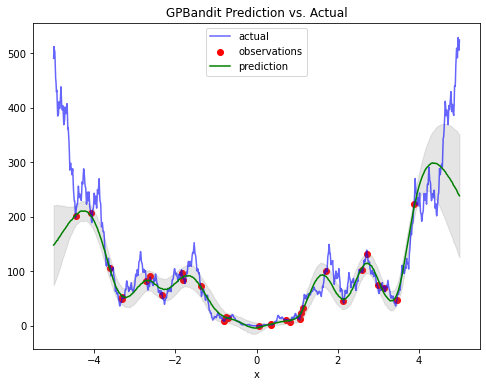

In [ ]:
plt.figure(figsize=(8, 6))

# Visualize the real objective function.
xs = np.linspace(-5, 5, num=1000)
ys = [f(x) for x in xs]
plt.plot(xs, ys, label='actual', color='blue', alpha=0.6)

# Visualize the observation points.
obs_x = [obs.parameters['x'].value for obs in observations]
obs_y = [f(x) for x in obs_x]
plt.scatter(obs_x, obs_y, label='observations', marker='o', color='red')

# Visualize the predictions and confidence bounds.
pred_x = [suggestion.parameters['x'].value for suggestion in suggestions]
plt.plot(pred_x, predictions.mean, label='prediction', color='green')
lower = predictions.mean - predictions.stddev
upper = predictions.mean + predictions.stddev
plt.fill_between(pred_x, lower, upper, color='grey', alpha=0.2)

# Add legend and title.
plt.legend(loc='best')
plt.title(f'GPBandit Prediction vs. Actual')
plt.xlabel('x')
plt.show()